In [2]:
from paddle.vision.datasets import Cifar10,MNIST
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ortho_group
import random

In [3]:
mnist_train = MNIST(
    mode= 'train',
    backend="cv2" 
)
cifar10_train = Cifar10(
    mode= 'train',
    backend="cv2"   # 指定要返回的图像类型：PIL.Image 或 numpy.ndarray。必须是 {'pil'，'cv2'} 中的值
)

In [4]:
img0,label0 = mnist_train[0]
img0 = img0.astype("uint16")

img1,label1 = cifar10_train[0]
img1 = img1.astype("uint16")

# RMT

In [5]:
class RMT:

    def __init__(self,image_size=(32,32), block_size = 4,Shuffle=False):

        self.img_size = image_size

        self.block_size = block_size

        self.block_num = int((image_size[0]/block_size)*(image_size[1]/block_size))

        self.RMT_Matrixes = self.Create_RMT()

        self.shuffle = Shuffle

    def normalize(self, img):

        img1 = img.astype(np.float32)

        return img1

    def Create_RMT(self):

        mats=[]

        for i in range(self.block_num):

            mats.append(ortho_group.rvs(dim=self.block_size))


        return mats

    def Add_Noise(self,blocks,N):

        block = []

        for i in blocks:

            noise = np.divide(np.random.randint(1, N, self.block_size*self.block_size).reshape(i.shape),255)

            block.append(i+noise)

        return blocks


    def M2block(self,array,noise_level=100, noise=False):

        h = array.shape[0]
        r = array.shape[1]

        blocks=[]

        hight = [i*self.block_size for i in range(int(h/self.block_size))]

        width = [i*self.block_size for i in range(int(r/self.block_size))]

        for i in hight:

            for j in width:

                blocks.append(array[i:i+self.block_size,j:j+self.block_size])

        if noise:

            return self.Add_Noise(blocks,noise_level)

        else:

            return blocks

    def block2M(self,block_list,seed=1):

        Row = []

        Column = []

        blocks=block_list

        if self.shuffle:

            random.Random(seed).shuffle(block_list)

        for i in range(self.block_num):

            if (i+1)%(self.img_size[1]/self.block_size)!=0:

                Row.append(blocks[i])

            else:

                Row.append(blocks[i])

                Column.append(np.hstack(Row))

                Row=[]

        return np.vstack(Column)

    def Encode(self,image,noise=True,noise_level=100,shuffling_seed=1):

        img = self.normalize(image)

        if len(img.shape) != 3:

            blocks = self.M2block(img,noise_level,noise)

            block_enc = [ np.matmul(blocks[i], self.RMT_Matrixes[i]) for i in range(len(blocks))]

            return self.block2M(block_enc)

        else:

            img2 = img.copy()

            for c in range(img.shape[2]):

                blocks = self.M2block(img[:,:,c])

                block_enc = [ np.matmul(blocks[i], self.RMT_Matrixes[i]) for i in range(len(blocks))]

                img2[:,:,c] = self.block2M(block_enc)

            return img2

    def RMT_M(self):

        return self.RMT_Matrixes


    def Estimate_block_list(self, Original, Encrypted):

        Original_blocks = []

        Encrypted_blocks = []

        Fin_O = []

        Fin_E = []

        if Original.shape[0] == Encrypted.shape[0]:

            for i in range(Original.shape[0]):

                Original_blocks.append(self.M2block(Original[i]))

                Encrypted_blocks.append(self.M2block(Encrypted[i]))

            for i in range(self.block_num):

                temp_o = []

                temp_e =[]

                for j in range(Original.shape[0]):

                    temp_o.append(Original_blocks[j][i])

                    temp_e.append(Encrypted_blocks[j][i])

                Fin_O.append(temp_o.copy())

                Fin_E.append(temp_e.copy())

        else:

            print("Clean dataset has different size with encrypted dataset")

        return Fin_O, Fin_E

    def block_list_recover(self,Fin_O,Fin_E):
    # For test
        img_num = len(Fin_O[0])

        block_o = []

        block_e = []

        temp_O = np.array(Fin_O)

        temp_E = np.array(Fin_E)

        for i in range(temp_O.shape[1]):

            temp_o2 = []

            temp_e2 = []

            for j in range(temp_O.shape[0]):

                temp_o2.append(temp_O[j,i,:,:])

                temp_e2.append(temp_E[j,i,:,:])

            img_o = self.block2M(temp_o2)

            img_e = self.block2M(temp_e2)

            block_o.append(img_o)

            block_e.append(img_e)

        return np.array(block_o), np.array(block_e)


    def Estimate_one_position(self,Original,Encrypted):

        (nrows, ncols) = Original[0].shape

        R = np.array([[]])

        X = Original[0]

        for j in range(1,len(Encrypted)):

            X = np.append(X,Original[j],0)

        det = np.linalg.det(np.dot(X.T,X))

        if det == 0:

            return []

        Xbar = np.dot(np.linalg.inv(np.dot(X.T,X)),X.T)

        for i in range(ncols):

            y = np.array(Encrypted[0][:,[i]])

            for j in range(1,len(Encrypted)):

                y = np.append(y, Encrypted[j][:,[i]],0)

            r = np.dot(Xbar,y)

            if i==0:

                R = r

            else:

                R=np.append(R,r,1)

        if np.linalg.det(R)==0:

            return []

        else:

            return R

    def Estimate_one_channel(self, Original, Encrypted):

        Original_blocks, Encrypted_blocks = self.Estimate_block_list(Original,Encrypted)

        RMT_Encoder = []

        for i in range(self.block_num):

            RMT_Encoder.append(self.Estimate_one_position(Original_blocks[i],Encrypted_blocks[i]))

        return RMT_Encoder

    def Estimate(self, Original, Encrypted):

        if len(Original.shape) < 4:

            return self.Estimate_one_channel(self.normalize(Original),Encrypted)

        elif len(Original.shape) == 4:

            print("RGB image, estimate for every channel")

            channels=[]

            for i in range(self.img_size[2]):

                channels.append(self.Estimate_one_channel(self.normalize(Original)[:,:,:,i],Encrypted[:,:,:,i]))

            return channels

    def Recover_one_channel(self,Encrypted,RMT_encoders):

        Blocks = self.M2block(Encrypted)

        Blocks_recovered = []

        for i in range(len(Blocks)):

            if len(RMT_encoders[i])==0:

                Blocks_recovered.append(np.zeros(Blocks[1].shape))

            else:

                Blocks_recovered.append(np.matmul(Blocks[i], np.linalg.inv(RMT_encoders[i])))

        return self.block2M(Blocks_recovered)

    def Recover(self,Encrypted,RMT_encoders):

        if len(Encrypted.shape) < 3:

            return self.Recover_one_channel(Encrypted,RMT_encoders)

        else:

            if len(RMT_encoders) == 3:

                img = np.zeros(self.img_size)

                for i in range(3):

                    img[:,:,i] = self.Recover_one_channel(Encrypted[:,:,i],RMT_encoders[i])

                return img

            else:

                img = np.zeros(shape = self.img_size)

                for i in range(3):

                    img[:,:,i] = self.Recover_one_channel(Encrypted[:,:,i],RMT_encoders)

                return img

In [6]:
encrypted_images = []

In [19]:
# Initializing the RMT encoder with the specified parameters

image_temp = img1
block_size = 2

noise_level = 0

if noise_level == 0:

    noise = False

    noise_level = 1
else:
    noise = True
    
# If adjusted row or col different from the original image, need padding
adjusted_row = (image_temp.shape[0] + int(block_size) - 1) // int(
                block_size) * int(block_size)

adjusted_col = (image_temp.shape[1] + int(block_size) - 1) // int(
                block_size) * int(block_size)

# Generate padding
if image_temp.shape[0] != adjusted_row or image_temp.shape[1] != adjusted_col:
    pad_row = adjusted_row - image_temp.shape[0]

    pad_col = adjusted_col - image_temp.shape[1]

else:
    pad_row = 0
    pad_col = 0
    
if len(image_temp.shape)==3:
    encoder = RMT(image_size=(image_temp.shape[0] + pad_row, image_temp.shape[1] + pad_col, image_temp.shape[2]),block_size=int(block_size),Shuffle=False)
else:
    encoder = RMT(image_size=(image_temp.shape[0] + pad_row, image_temp.shape[1] + pad_col),block_size=int(block_size),Shuffle=False)
    
if image_temp.shape[0] != adjusted_row or image_temp.shape[1] != adjusted_col:

    if len(image_temp.shape) == 3:  # RGB image

        image_padded = np.pad(image_temp, ((0, pad_row), (0, pad_col), (0, 0)), mode='edge')

    else:  # Grayscale image
        image_padded = np.pad(image_temp, ((0, pad_row), (0, pad_col)), mode='edge')

else:

    image_padded = image_temp

encrypted_img_array = encoder.Encode(image_padded, noise=noise, noise_level=noise_level)

In [20]:
encrypted_images.append(encrypted_img_array)

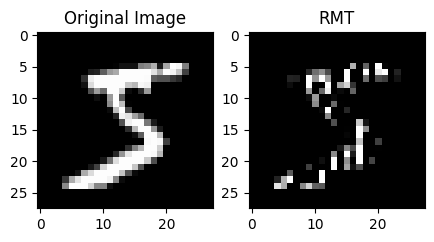

In [21]:
# 显示原始图像和加密的图像
fig, axs = plt.subplots(1, 2, figsize=(5, 5))  
axs[0].imshow(img0, cmap='gray')  
axs[0].set_title('Original Image')  
axs[1].imshow(np.clip(encrypted_images[0], 0, 255).astype(np.uint8), cmap='gray')  
axs[1].set_title('RMT')
plt.show()

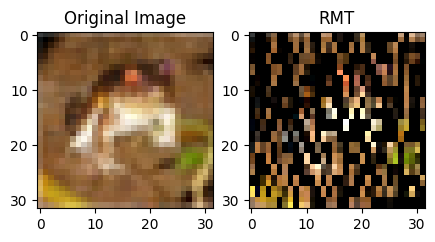

In [22]:
# 显示原始图像和加密的图像
fig, axs = plt.subplots(1, 2, figsize=(5, 5))  
axs[0].imshow(img1)  
axs[0].set_title('Original Image')  
axs[1].imshow(np.clip(encrypted_images[1], 0, 255).astype(np.uint8))  
axs[1].set_title('RMT')  
plt.show()